# mamba
## 获取数据

In [1]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2024, 1, 1)
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open     High       Low     Close    Volume
Date                                                       
2018-01-02   52.6510   53.799   52.6510   53.6720  31753540
2018-01-03   53.6965   54.805   53.6715   54.5760  31305800
2018-01-04   54.8545   55.204   54.7130   54.8000  26049960
2018-01-05   55.1725   55.679   55.0900   55.5145  30238600
2018-01-08   55.5500   55.958   55.5000   55.7105  24626920
...              ...      ...       ...       ...       ...
2023-12-22  140.7700  141.990  140.7100  141.4900  26532199
2023-12-26  141.5900  142.680  141.1900  141.5200  16780333
2023-12-27  141.5900  142.080  139.8860  140.3700  19628618
2023-12-28  140.7800  141.140  139.7500  140.2300  16045712
2023-12-29  139.6300  140.360  138.7800  139.6900  18733017

[1509 rows x 5 columns]


In [2]:
mem_his_days=5
per_days=10

# 股票数据
df['label'] = df['Close'].shift(-per_days)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,1:-1])

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)
print(len(X_lately))

(1495, 5, 4)
(1495,)
10


## 制作数据集

In [3]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(X_lately))

(1345, 5, 4)
(1345,)
(150, 5, 4)
(150,)
10


## 建立模型

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
from model import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split

# 训练数据
batch, length, dim = 64, 5, 4
# noise = np.random.normal(sca_X.mean(), 0.05*sca_X.std(), X_train.shape)
# X_train += noise
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x):
        x = self.fc1(x)
        x = self.mamba(x)
        x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(x)
        return x

# 初始化模型
model = SequenceModel(input_dim=dim, model_dim=32, state_dim=16, conv_width=4, expand_factor=2, output_dim=1)
print(model)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 训练模型
losses = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    losses_batch = []
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        losses_batch.append(loss.item())
    loss_batch = sum(losses_batch)/len(losses_batch)
    losses.append(loss_batch)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



e:\program\anaconda3\envs\yk_lstm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SequenceModel(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=32, out_features=128, bias=False)
    (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
    (x_proj): Linear(in_features=64, out_features=34, bias=False)
    (dt_proj): Linear(in_features=2, out_features=64, bias=True)
    (out_proj): Linear(in_features=64, out_features=32, bias=False)
  )
  (fc2): Linear(in_features=160, out_features=1, bias=True)
)
Epoch [5/50], Loss: 3285.7744
Epoch [10/50], Loss: 9108.8047
Epoch [15/50], Loss: 3075.9692
Epoch [20/50], Loss: 8702.5361
Epoch [25/50], Loss: 2180.8389


KeyboardInterrupt: 

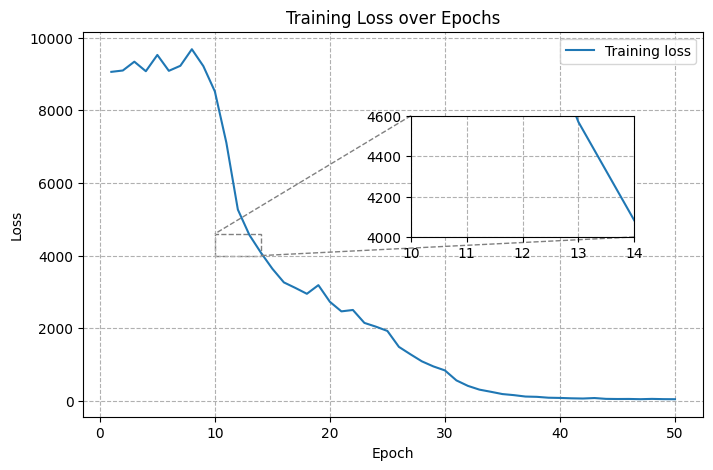

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# 数据
x = np.linspace(1,num_epochs)
y = np.array(losses)
fig, ax = plt.subplots(figsize=(8, 5))
# 主图
plt.plot(x,y, label='Training loss')
ax.grid(True, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
# 子图
inset_ax = inset_axes(ax, width="45%", height="45%", loc='upper right', 
                      bbox_to_anchor=(0.1, 0.1, 0.8, 0.7), bbox_transform=ax.transAxes)
inset_ax.plot(x, y)
inset_ax.set_xlim(10, 14)  # 设置X轴范围
inset_ax.set_ylim(4000, 4600)  # 设置Y轴范围
inset_ax.grid(True, linestyle='--')
# 连接线
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5",linestyle="--")


plt.show()

## 预测

In [ ]:
# 预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

print(f"Predicted shape: {y_pred.shape}")
# 计算MAPE
y_pred = y_pred.to('cpu').numpy()
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print(f'MAPE on test set: {mape:.4f}')


Predicted shape: torch.Size([150, 1])
MAPE on test set: 42.0789


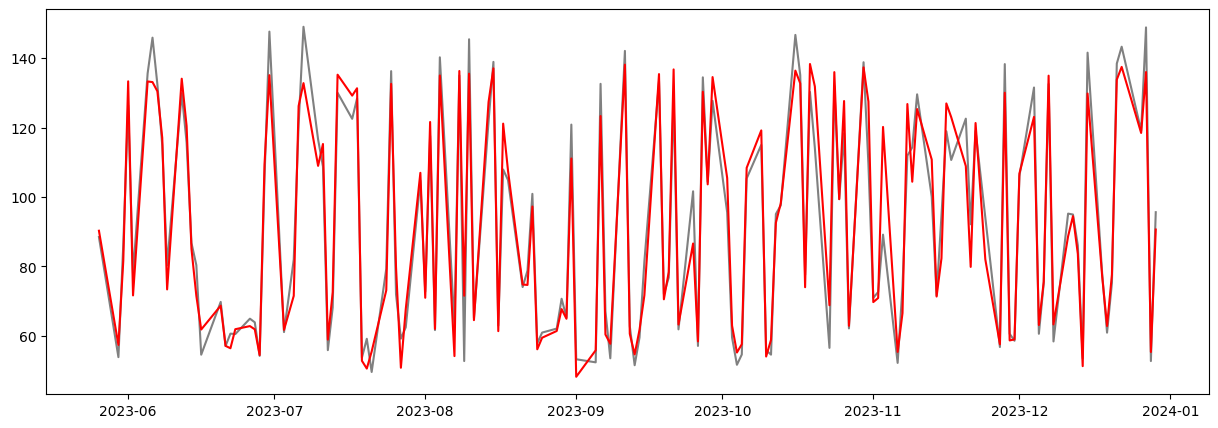

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_test,color='gray',label='price')
plt.plot(df_time,y_pred,color='red',label='predict')
plt.show()

## 结果评价

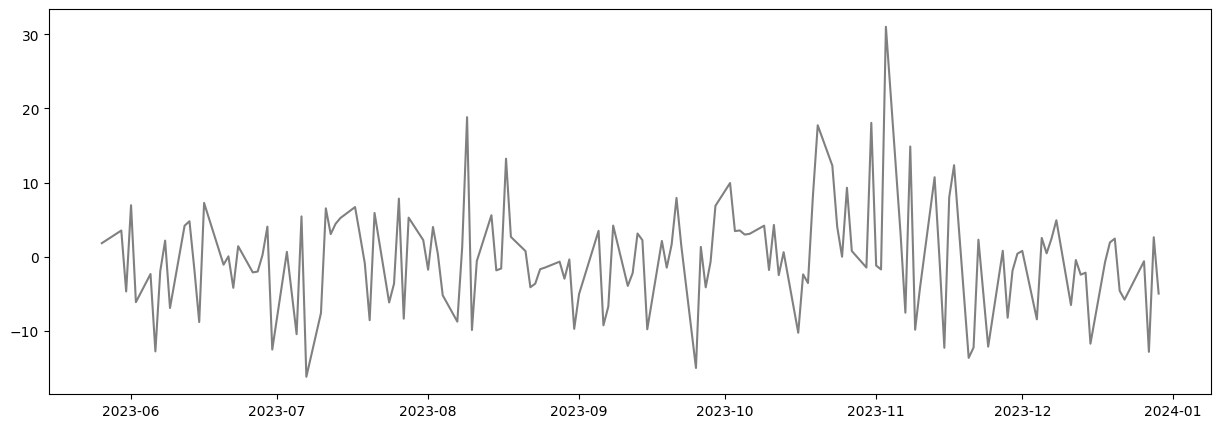

In [ ]:
# 计算残差
y_e = y_pred[:,0]-y_test
plt.figure(figsize=(15, 5))
df_time = df.index[-len(y_test):]
plt.plot(df_time,y_e,color='gray',label='price')
plt.show()

In [ ]:
# 对残差纯随机性检验
import numpy as np
import statsmodels.api as sm

data = y_e
# 进行 LBQ 检验，设置 lags 参数为需要检验的自相关阶数
lags = 10  # 选择检验的最大自相关阶数
lbq_test = sm.stats.acorr_ljungbox(data, lags=lags)
print(lbq_test)

# lb_stat 越小，残差自相关性越弱
# p 大于 0.05 才支持 纯随机 假设

      lb_stat  lb_pvalue
1    0.255495   0.613233
2    0.805733   0.668401
3   14.030069   0.002865
4   14.033241   0.007190
5   18.382536   0.002503
6   23.243012   0.000719
7   24.069289   0.001108
8   24.777417   0.001695
9   26.893130   0.001457
10  28.226300   0.001661


# aa

In [22]:
from model import Mamba, ModelArgs,MambaBlock
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
from model import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
import torch
batch, length, dim = 4, 128, 4
x = torch.randn(batch, length, dim)
y_l = torch.randn(batch, length,1)
args = ModelArgs(d_model=dim,d_state=32,expand=2,
                 n_layer=64,d_conv=4,vocab_size=3)
model = MambaBlock(args)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)

# 训练模型
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y = model(x)
    loss = criterion(y, y_l)
    loss.backward()
    optimizer.step()
print("A: ",model.A_log.shape)
print("B: ",model.Bs)
print("C: ",model.Cs)
print("D: ",model.D.shape)

MambaBlock(
  (in_proj): Linear(in_features=4, out_features=16, bias=False)
  (conv1d): Conv1d(8, 8, kernel_size=(4,), stride=(1,), padding=(3,), groups=8)
  (x_proj): Linear(in_features=8, out_features=65, bias=False)
  (dt_proj): Linear(in_features=1, out_features=8, bias=True)
  (out_proj): Linear(in_features=8, out_features=4, bias=False)
)
A:  torch.Size([8, 32])
B:  torch.Size([4, 128, 32])
C:  torch.Size([4, 128, 32])
D:  torch.Size([8])


e:\program\anaconda3\envs\yk_lstm\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4, 128, 1])) that is different to the input size (torch.Size([4, 128, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [3]:
print(model.A_log.shape)
print(model.Bs)
print(model.C)
print(model.D.shape)
# model.args.

torch.Size([10, 16])
torch.Size([2, 64, 16])
torch.Size([2, 64, 16])
torch.Size([10])


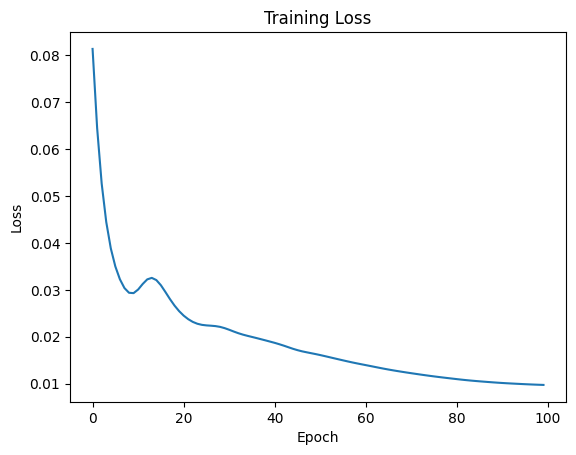

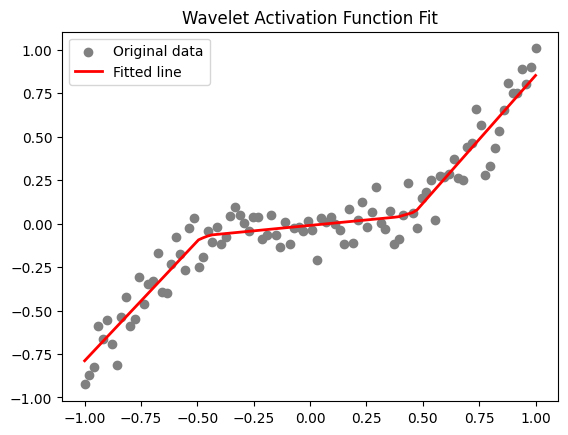

In [132]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 定义Haar小波函数
def haar_wavelet(x):
    # Haar小波函数的定义
    condition = (x >= 0) & (x < 1)
    return torch.where(condition, 1.0, -1.0)

# 定义高斯径向基函数
def Daubechies(x):
    y = np.cos(1.75 * x) * np.exp(-x**2 / 2.0)
    return y

# 定义一个简单的神经网络模型
class WaveletNet(torch.nn.Module):
    def __init__(self):
        super(WaveletNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, 10)  # 输入特征为1，输出特征为10
        self.fc2 = torch.nn.Linear(10, 1)  # 输入特征为10，输出特征为1

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)  # 这里使用ReLU作为隐层激活函数，也可以替换为小波基函数
        # x = haar_wavelet(x)
        x = self.fc2(x)
        return x

# 生成一些示例数据
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)
y = x.pow(3) + 0.1 * torch.randn(x.size())

# 实例化模型和优化器
model = WaveletNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# 训练模型
losses = []
num_epochs = 100
for epoch in range(num_epochs):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# 绘制损失曲线
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 绘制拟合曲线
model.eval()
with torch.no_grad():
    y_pred = model(x)
plt.scatter(x.numpy(), y.numpy(), color='gray', label='Original data')
plt.plot(x.numpy(), y_pred.numpy(), color='red', linewidth=2, label='Fitted line')
plt.legend()
plt.title('Wavelet Activation Function Fit')
plt.show()


In [134]:
x = np.linspace(-1,1,40)
y = x
plt.plot(x,F.relu(x))
plt.grid(True, linestyle='--')
plt.show()


TypeError: relu(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [127]:
Daubechies(x)

array([-1.12445367, -1.26977651, -1.41424466, -1.34129865, -1.19625111,
       -1.05120356, -0.90615602, -0.76110847, -0.61606093, -0.47101338,
       -0.32596584, -0.18091829, -0.03587075,  0.10917679,  0.25422434,
        0.39927188,  0.54431943,  0.68936697,  0.83441452,  0.97946206,
        1.12445367,  1.26977651,  1.41424466])